In [25]:
from boltzmann_machines.cp_rtrbm import RTRBM
from data.poisson_data import poisson_data
from utils.plots import *
from utils.map_hidden_structure import MapHiddenStructure
from utils.moments_plot import *

In [11]:
def poisson_data(n_batches=50, n_pop=5, n_per_pop=20, T=100, fr=None, correlation=.8, snr=20):
    if fr is None:
        fr = torch.linspace(.1, .5, n_pop)
    data = torch.empty(n_pop * n_per_pop, T, n_batches)
    for batch in range(n_batches):
        data[..., batch] = poisson_data_batch(n_pop, n_per_pop, fr, T, correlation, snr)
    return data


def poisson_data_batch(n_pop, n_per_pop, fr, T, correlation, snr):
    for i in range(n_pop):
        mother_train = constant_mother_train(fr[i] / correlation, T)

        for n in range(n_per_pop):
            spikes = mother_train.expand(n_per_pop, T)
            spikes = spikes - spikes * (torch.rand(n_per_pop, T) > correlation)
            spikes = spikes + (spikes == 0) * (torch.rand(n_per_pop, T) < (correlation / snr))

            spikes[spikes > 1] = 1
        if i == 0:
            data = spikes.clone().detach()
        else:
            data = torch.cat((data, spikes), dim=0)
    return data


def constant_mother_train(fr, steps):
    rates = fr * torch.ones(steps)
    mother_train = torch.poisson(rates)
    return mother_train


In [13]:
# create data
data = poisson_data(n_batches=50, n_pop=5, n_per_pop=20, T=100, correlation=.8, snr=20)

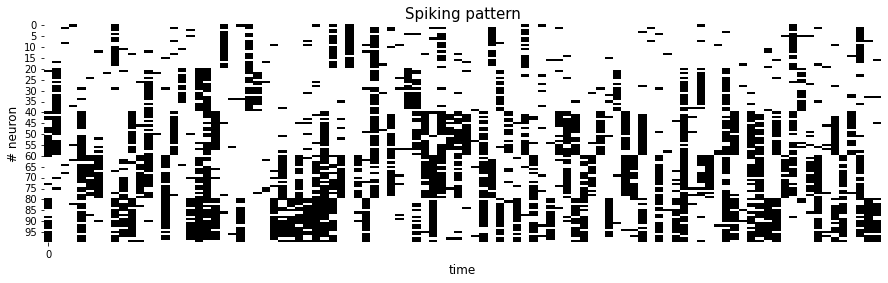

In [16]:
raster_plot(data[..., 0])
plt.show()

In [ ]:
plt.plot

In [18]:
# run RTRBM with 5 hiddens
rtrbm = RTRBM(data, N_H=5, debug_mode=True, device='cpu')
rtrbm.learn(n_epochs=50, lr_schedule='linear_decay', max_lr=1e-4, min_lr=1e-6, batch_size=1)

100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


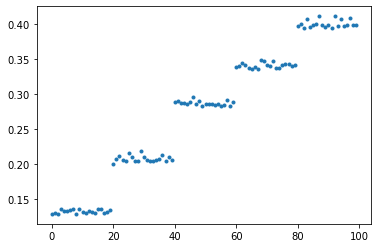

In [17]:
plt.plot(torch.mean(data, (1, 2)), '.')

In [11]:
torch.save(rtrbm, '../../data/RTRBMs/Poisson Drawn Data/rtrbm.pt')

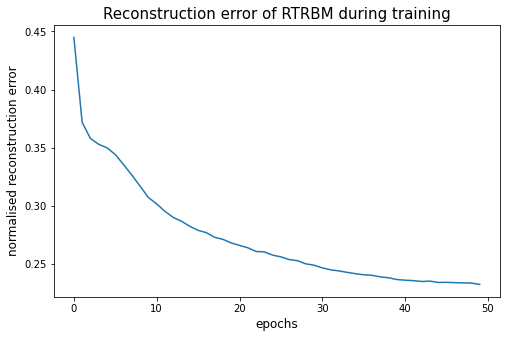

In [19]:
plot_reconstruction_error(rtrbm.errors)
plt.show()

100%|██████████| 50/50 [00:01<00:00, 28.96it/s]


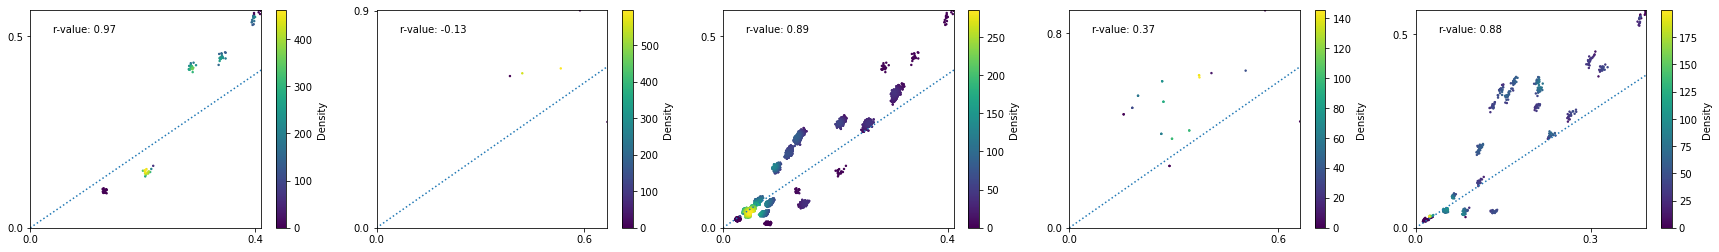

In [20]:
x = infer_and_get_moments_plot(rtrbm=rtrbm, test=data, pre_gibbs_k=0, gibbs_k=1)

In [19]:
torch.save(rtrbm, '../../data/RTRBMs/Poisson Drawn Data/rtrbm1.pt')

100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


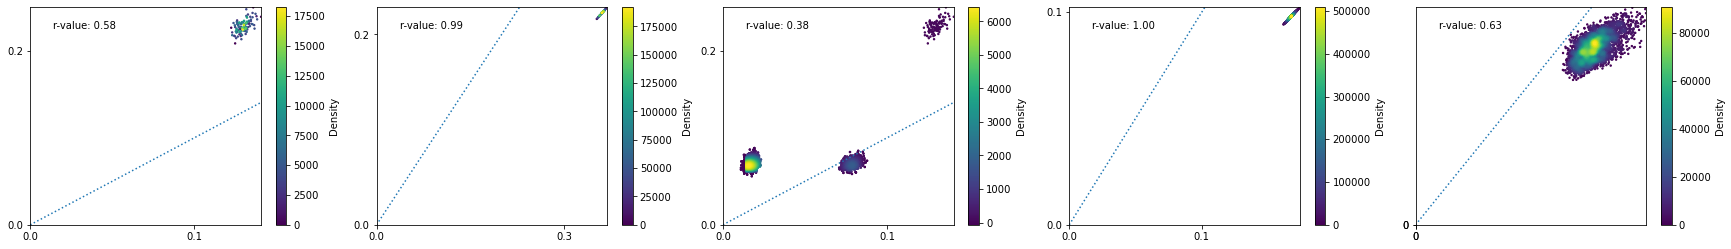

In [21]:
torch.save
x = infer_and_get_moments_plot('../../data/RTRBMs/Poisson Drawn Data/rtrbm1.pt', data, pre_gibbs_k=100, gibbs_k=10)

In [22]:
def gen_data(n_v, T):
    fr = torch.outer(torch.rand(n_v), torch.ones(T))
    data = torch.poisson(fr)
    return data

In [23]:
data = gen_data(100, 100)

In [24]:
result = RTRBM(data, N_H=10, device='cpu', debug_mode=True)
result.learn(n_epochs=2000, lr_schedule='geometric_decay', min_lr=1e-6, max_lr=1e-4, start_decay=200, batch_size=1, save_every_n_epochs=10)

100%|██████████| 2000/2000 [01:14<00:00, 26.69it/s]


In [31]:
rt = result.visible_to_expected_hidden(data)
ht, _ = result.visible_to_hidden(data, rt)
vs, hs = result.sample(data[:, 0], chain=data.shape[1])

100%|██████████| 100/100 [00:01<00:00, 79.17it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

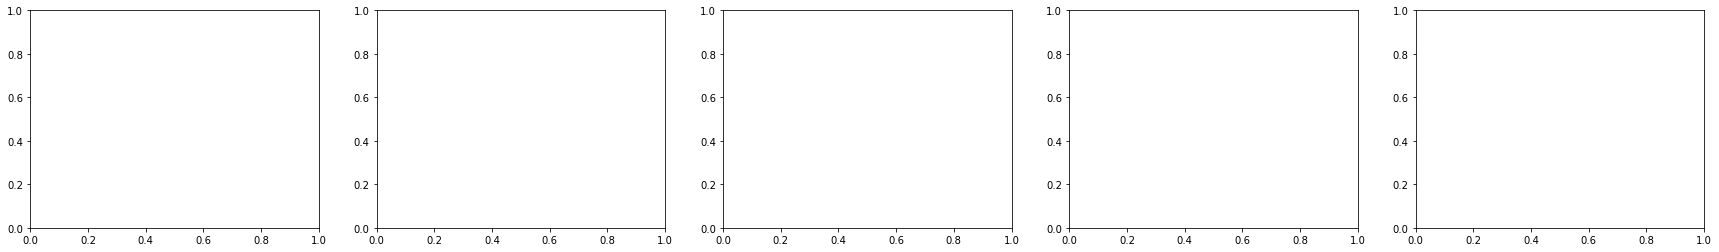

In [33]:
vvt, vvs, vht, vhs, hht, hhs = calculate_moments(data, ht, vs, hs)
ax = density_plot_moments(torch.mean(data, 1), torch.mean(vs, 1), torch.mean(ht, 1), torch.mean(hs, 1), vvt, vvs, vht, vhs, hht, hhs)